In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison
from utils.modeling import fit_cv_models, predict_cv_ensemble
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)

def add_engineered_features(df):
    df['log_PiO2'] = np.log(df['PiO2(kPa)'])
    df['SpO2_squared'] = df['SpO2(%)'] ** 2
    df['saturation_deficit'] = 100 - df['SpO2(%)']
    df = add_shift_raw_column(df, spo2_to_po2)  # if not already present
    return df

train_df_engineered = add_engineered_features(train_df)
test_df_engineered = add_engineered_features(test_df)
val_df_engineered = add_engineered_features(val_df)

features = ['shift_raw', 'log_PiO2', 'SpO2_squared', 'saturation_deficit']


In [6]:
from sklearn.linear_model import LinearRegression

# Filter subsets where SpO2 < 92.5%
train_sub = train_df_engineered[train_df_engineered['SpO2(%)'] < 92.5]
test_sub = test_df_engineered[test_df_engineered['SpO2(%)'] < 92.5]
val_sub = val_df_engineered[val_df_engineered['SpO2(%)'] < 92.5]

X_train = train_sub[features]
y_train = train_sub['shift']

X_test = test_sub[features]
y_test = test_sub['shift']

X_val = val_sub[features]
y_val = val_sub['shift']

# Train linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
test_pred = lr.predict(X_test)
val_pred = lr.predict(X_val)

test_sub['y_pred'] = test_pred
val_sub['y_pred'] = val_pred

test_summary = evaluate_macro_patient_level(test_sub, y_true_col='shift', y_pred_col='y_pred')
val_summary = evaluate_macro_patient_level(val_sub, y_true_col='shift', y_pred_col='y_pred')

# Evaluate using provided functions
print("Test set evaluation:")
print_evaluation(test_summary)

print("Validation set evaluation:")
print_evaluation(val_summary)

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_8477/4152743206.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sub['y_pred'] = test_pred
/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_8477/4152743206.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_sub['y_pred'] = val_pred


Test set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.645
MSE  = 1.453
RMSE = 0.745
Mean Bias Error = 0.151
MAPE = 6.075%
nRMSE = 4.345%
Validation set evaluation:
Macro-averaged per-patient metrics:
MAE  = 0.518
MSE  = 0.662
RMSE = 0.558
Mean Bias Error = 0.020
MAPE = 4.421%
nRMSE = 2.860%


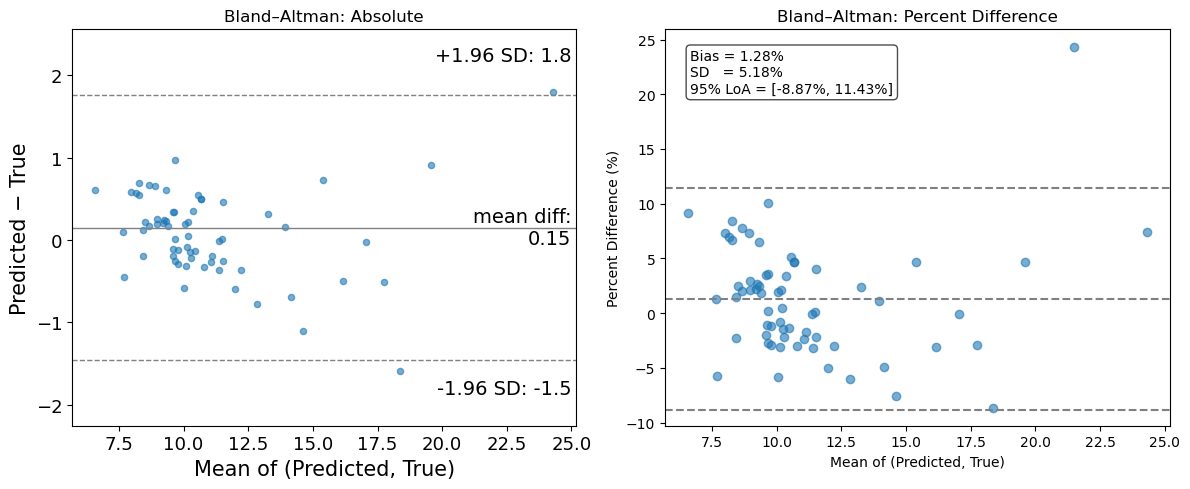

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [8]:
bland_altman_plots(test_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


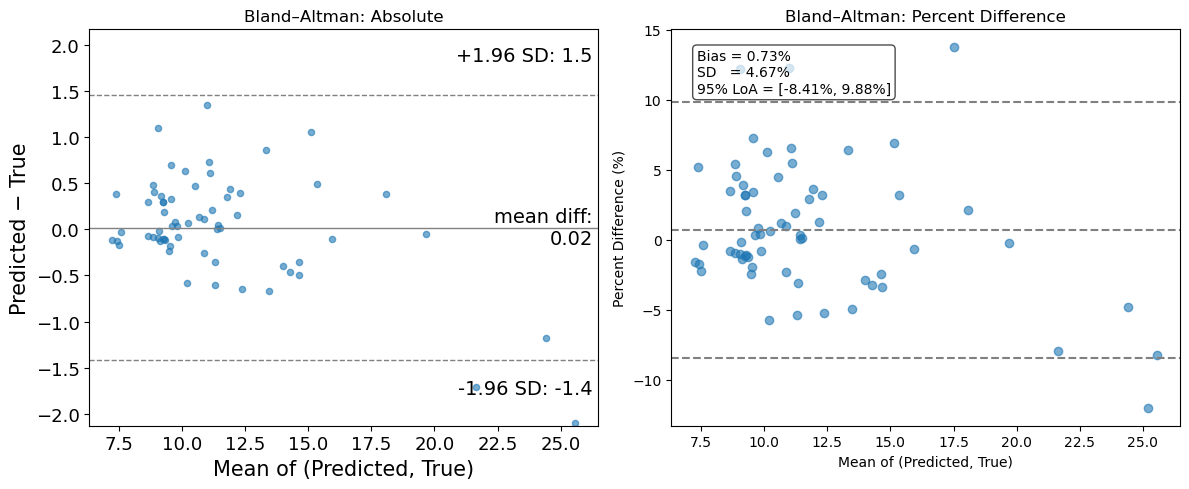

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Bland–Altman: Absolute'}, xlabel='Mean of (Predicted, True)', ylabel='Predicted − True'>,
        <Axes: title={'center': 'Bland–Altman: Percent Difference'}, xlabel='Mean of (Predicted, True)', ylabel='Percent Difference (%)'>],
       dtype=object))

In [9]:
bland_altman_plots(val_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')


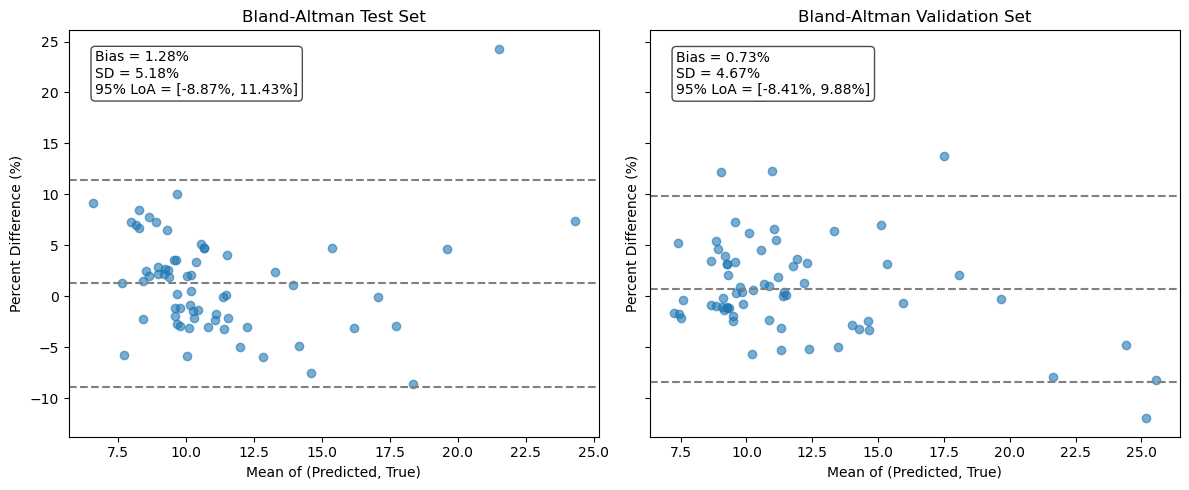

In [10]:
fig, axs = bland_altman_pct_comparison(test_sub, val_sub, y_true_col='shift', y_pred_col='y_pred', group_col='Anon.Patient_ID')

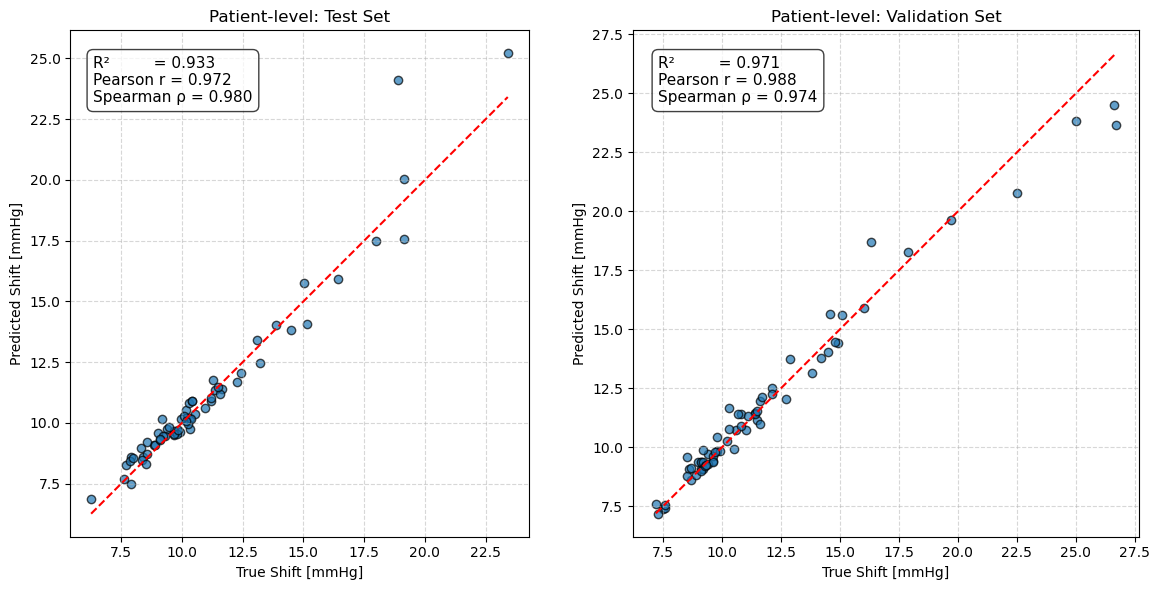

In [13]:

from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

# Group by patient and take mean shift and prediction per patient
test_avg = test_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].mean().reset_index()
val_avg = val_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].mean().reset_index()

# Compute stats
r2_test = r2_score(test_avg['shift'], test_avg['y_pred'])
pearson_test, _ = pearsonr(test_avg['shift'], test_avg['y_pred'])
spearman_test, _ = spearmanr(test_avg['shift'], test_avg['y_pred'])

r2_val = r2_score(val_avg['shift'], val_avg['y_pred'])
pearson_val, _ = pearsonr(val_avg['shift'], val_avg['y_pred'])
spearman_val, _ = spearmanr(val_avg['shift'], val_avg['y_pred'])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Test set
axs[0].scatter(test_avg['shift'], test_avg['y_pred'], alpha=0.7, edgecolors='k')
axs[0].plot([test_avg['shift'].min(), test_avg['shift'].max()],
            [test_avg['shift'].min(), test_avg['shift'].max()], 'r--', label='Identity line')
axs[0].set_title("Patient-level: Test Set")
axs[0].set_xlabel("True Shift [mmHg]")
axs[0].set_ylabel("Predicted Shift [mmHg]")
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(True, linestyle='--', alpha=0.5)
textstr_test = (
    f"R²         = {r2_test:.3f}\n"
    f"Pearson r = {pearson_test:.3f}\n"
    f"Spearman ρ = {spearman_test:.3f}"
)
axs[0].text(0.05, 0.95, textstr_test, transform=axs[0].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

# Validation set
axs[1].scatter(val_avg['shift'], val_avg['y_pred'], alpha=0.7, edgecolors='k')
axs[1].plot([val_avg['shift'].min(), val_avg['shift'].max()],
            [val_avg['shift'].min(), val_avg['shift'].max()], 'r--', label='Identity line')
axs[1].set_title("Patient-level: Validation Set")
axs[1].set_xlabel("True Shift [mmHg]")
axs[1].set_ylabel("Predicted Shift [mmHg]")
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(True, linestyle='--', alpha=0.5)
textstr_val = (
    f"R²         = {r2_val:.3f}\n"
    f"Pearson r = {pearson_val:.3f}\n"
    f"Spearman ρ = {spearman_val:.3f}"
)
axs[1].text(0.05, 0.95, textstr_val, transform=axs[1].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

plt.tight_layout()
plt.show()

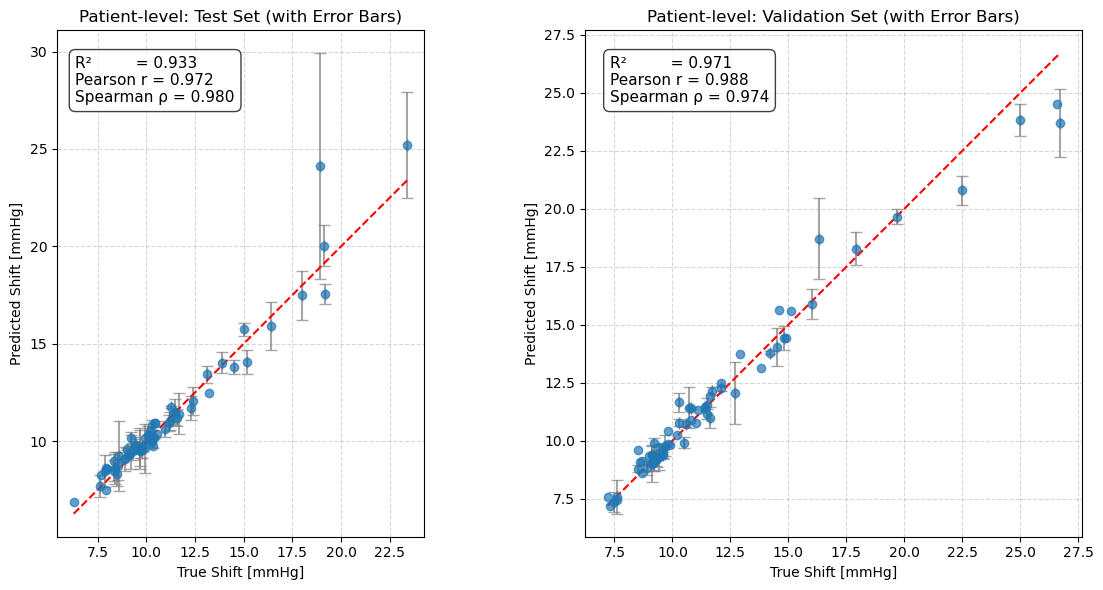

In [14]:
# Compute standard deviations for each patient
test_stats = test_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].agg(['mean', 'std']).reset_index()
val_stats = val_sub.groupby('Anon.Patient_ID')[['shift', 'y_pred']].agg(['mean', 'std']).reset_index()

# Extract values for plotting
test_y_true_avg = test_stats[('shift', 'mean')]
test_y_true_std = test_stats[('shift', 'std')]
test_y_pred_avg = test_stats[('y_pred', 'mean')]
test_y_pred_std = test_stats[('y_pred', 'std')]

val_y_true_avg = val_stats[('shift', 'mean')]
val_y_true_std = val_stats[('shift', 'std')]
val_y_pred_avg = val_stats[('y_pred', 'mean')]
val_y_pred_std = val_stats[('y_pred', 'std')]

# Plot with error bars
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Test set
axs[0].errorbar(test_y_true_avg, test_y_pred_avg,
                xerr=test_y_true_std, yerr=test_y_pred_std,
                fmt='o', alpha=0.7, ecolor='gray', capsize=4)
axs[0].plot([test_y_true_avg.min(), test_y_true_avg.max()],
            [test_y_true_avg.min(), test_y_true_avg.max()], 'r--')
axs[0].set_title("Patient-level: Test Set (with Error Bars)")
axs[0].set_xlabel("True Shift [mmHg]")
axs[0].set_ylabel("Predicted Shift [mmHg]")
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].text(0.05, 0.95, textstr_test, transform=axs[0].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

# Validation set
axs[1].errorbar(val_y_true_avg, val_y_pred_avg,
                xerr=val_y_true_std, yerr=val_y_pred_std,
                fmt='o', alpha=0.7, ecolor='gray', capsize=4)
axs[1].plot([val_y_true_avg.min(), val_y_true_avg.max()],
            [val_y_true_avg.min(), val_y_true_avg.max()], 'r--')
axs[1].set_title("Patient-level: Validation Set (with Error Bars)")
axs[1].set_xlabel("True Shift [mmHg]")
axs[1].set_ylabel("Predicted Shift [mmHg]")
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].text(0.05, 0.95, textstr_val, transform=axs[1].transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.75))

plt.tight_layout()
plt.show()
